In [39]:
%load_ext autoreload
%autoreload 2
%aimport


Modules to reload:
all-except-skipped

Modules to skip:



In [23]:
import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm
import pandas as pd
import h5py

# Read mass accretion data

In [24]:
# snapshots and redshifts 
metadata_file = "../../data/processed/tng/tng300-1-table.csv"

snaps = np.arange(100)
metadata = pd.read_csv(metadata_file)
zs = metadata["Redshift"].values
scales = 1 / (1 + zs)
snaps.shape, zs.shape, scales.shape

((100,), (100,), (100,))

In [25]:
# read in trees, matches

with open("../../data/tng/tng100_trees.npz", 'rb') as f:
    npz_data = np.load(f)
    tbar = npz_data['tbar']
    tdmo = npz_data['tdmo']
    bbar = npz_data['bbar']
    bdmo = npz_data['bdmo']
    matches = npz_data['matches']

tbar.shape, tdmo.shape, bbar.shape, bdmo.shape, matches.shape

((4038, 100), (19049, 100), (4038,), (19049,), (4038,))

In [26]:
# apply cuts

# extract haloes and MAHs within given present-day mass range
# with no errors, exist in present day and matches with DMO 
mah_dmo = [] 
mah_bar = []
dmo_id = [] 
bar_id = []
dmo_is_sub = []
bar_is_sub = [] 
dmo_mpeak_pre = []
bar_mpeak_pre = []

for ii in tqdm(range(len(tbar))):
    match = matches[ii]
    if match != -1: 
                
        ok_dmo = ~bdmo['is_err'][match]
        ok_bar = ~bbar['is_err'][ii]
        
        mvir_dmo = tdmo['mdm'][match]
        mvir_bar = tbar['mdm'][ii]
        assert mvir_dmo.shape == (100,)
        dmo_mah = np.log10(mvir_dmo, out=np.zeros_like(mvir_dmo), where=(mvir_dmo!=0))
        bar_mah = np.log10(mvir_bar, out=np.zeros_like(mvir_bar), where=(mvir_bar!=0))

        # extract id (present)
        dmo_subfind_id = tdmo['subfind_id'][match, -1]
        bar_subfind_id = tbar['subfind_id'][ii, -1]

        # extract whether halo is central or not (present)
        dmo_is_sub_ii = tdmo['is_sub'][match, -1]
        bar_is_sub_ii = tbar['is_sub'][ii, -1]

        
        # should also check if halo exists in present day
        mpeak_pre_dmo = np.log10(bdmo['mpeak_pre'][match])
        mpeak_pre_bar = np.log10(bbar['mpeak_pre'][ii])
        
        is_cut_dmo = (mpeak_pre_dmo > 11.5) & ( mpeak_pre_dmo < 12) & (tdmo['mvir'][match,-1] > 0)
        is_cut_bar = (mpeak_pre_bar > 11.5) & ( mpeak_pre_bar < 12) & (tbar['mvir'][ii,-1] > 0)
        
        if ok_dmo & is_cut_dmo & ok_bar & is_cut_bar:
            mah_dmo.append(dmo_mah)
            mah_bar.append(bar_mah)
            dmo_id.append(dmo_subfind_id)
            bar_id.append(bar_subfind_id)
            dmo_is_sub.append(dmo_is_sub_ii)
            bar_is_sub.append(bar_is_sub_ii)
            dmo_mpeak_pre.append(mpeak_pre_dmo)
            bar_mpeak_pre.append(mpeak_pre_bar)



  0%|          | 0/4038 [00:00<?, ?it/s]

100%|██████████| 4038/4038 [00:00<00:00, 33078.52it/s]


In [27]:
# stack them into arrays
dmo_id = np.array(dmo_id)
bar_id = np.array(bar_id)

mah_dmo = np.concatenate([m.reshape(1, 100) for m in mah_dmo], axis=0)
mah_bar = np.concatenate([m.reshape(1, 100) for m in mah_bar], axis=0)

dmo_is_sub = np.array(dmo_is_sub)
bar_is_sub = np.array(bar_is_sub)

dmo_mpeak_pre = np.array(dmo_mpeak_pre)
bar_mpeak_pre = np.array(bar_mpeak_pre)

mah_dmo.shape, mah_bar.shape, dmo_id.shape, bar_id.shape, bar_is_sub.shape, dmo_mpeak_pre.shape, bar_mpeak_pre.shape

((1642, 100), (1642, 100), (1642,), (1642,), (1642,), (1642,), (1642,))

In [28]:
# make sure they are sorted according to ids (easier to do additional matching later)
sorted_mask = np.argsort(bar_id)
bar_id = bar_id[sorted_mask]
dmo_id = dmo_id[sorted_mask]
mah_dmo = mah_dmo[sorted_mask]
mah_bar = mah_bar[sorted_mask]
dmo_is_sub = dmo_is_sub[sorted_mask]
bar_is_sub = bar_is_sub[sorted_mask]
dmo_mpeak_pre = dmo_mpeak_pre[sorted_mask]
bar_mpeak_pre = bar_mpeak_pre[sorted_mask]
assert np.all(sorted(bar_id) == bar_id)

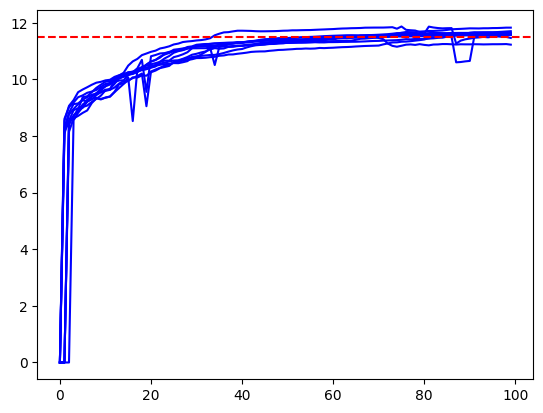

In [29]:
# random trees
indices = np.random.choice(len(mah_bar), size=10)
for idx in indices:
    plt.plot(mah_bar[idx], color='b')
plt.axhline(11.5, linestyle='--', color='r')

# Get trees in correct format

In [30]:
# interpolate to avoid missing snaps
from numpy import interp
mah_bar_interp = []
for ii in range(mah_bar.shape[0]):
    mah_ii = mah_bar[ii]
    is_zero = mah_ii == 0
    interp_ii = interp(scales, scales[~is_zero], mah_ii[~is_zero])
    mah_bar_interp.append(interp_ii.reshape(1, -1))

mah_bar_interp = np.concatenate(mah_bar_interp, axis=0)

In [31]:
# dmo too
from numpy import interp
mah_dmo_interp = []
for ii in range(mah_dmo.shape[0]):
    mah_ii = mah_dmo[ii]
    is_zero = mah_ii == 0
    interp_ii = interp(scales, scales[~is_zero], mah_ii[~is_zero])
    mah_dmo_interp.append(interp_ii.reshape(1, -1))

mah_dmo_interp = np.concatenate(mah_dmo_interp, axis=0)

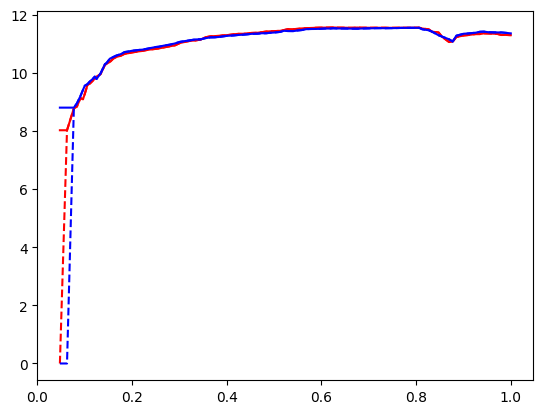

In [32]:
# it works
plt.plot(scales, mah_bar[17], linestyle='--', color='r')
plt.plot(scales, mah_bar_interp[17], color='r')
plt.plot(scales, mah_dmo[17], color='b', linestyle='--')
plt.plot(scales, mah_dmo_interp[17], color='b')


In [33]:
#  now we get mpeak from these trees
from multicam.tng.utils import get_mpeak_from_mah
mpeak_bar = get_mpeak_from_mah(mah_bar_interp)
mpeak_dmo = get_mpeak_from_mah(mah_dmo_interp)

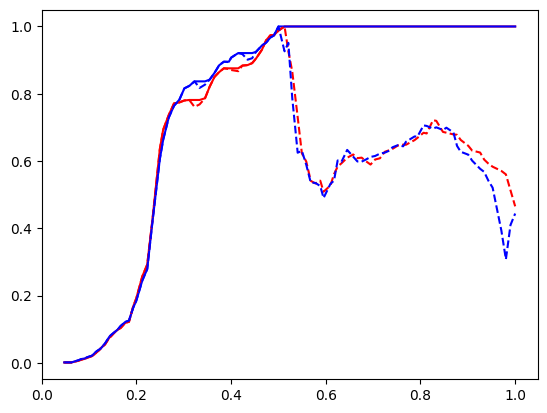

In [34]:
# looks like mpeak worked
idx = np.random.choice(range(mpeak_bar.shape[0]))
plt.plot(scales, mpeak_bar[idx], linestyle='-', color='r')
plt.plot(scales, mpeak_dmo[idx], linestyle='-', color='b')

plt.plot(scales, 10**mah_bar_interp[idx]/10**(np.max(mah_bar_interp[idx])), color='r', linestyle='--')
plt.plot(scales, 10**mah_dmo_interp[idx]/10**(np.max(mah_dmo_interp[idx])), color='b', linestyle='--')


# Read in masses (including stellar) from TNG files

In [1]:
import h5py
file0 = '../../data/tng/100-dark/fof_subhalo_tab_099.0.hdf5'
opened_file = h5py.File(file0, 'r')

In [11]:
with h5py.File('../../data/tng/100-dark/fof_subhalo_tab_099.0.hdf5', 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>


In [ ]:
my_list = []
for ii in range(100):
    with open(f"filename{ii}.txt", 'r') as f:
        # manipuldate file ... 
        data = f.get_data()
        my_list.append(data)

my_list #will have all the data from all files
# closed file 
print('hello')

In [15]:
import h5py 
from tqdm import tqdm
import numpy as np
subhalo_ids = []
subhalo_mass = []
count = 0

for ii in tqdm(range(0, 448)):
    filename = f'../../data/tng/100/fof_subhalo_tab_099.{ii}.hdf5'
    with h5py.File(filename, 'r') as f:
        if 'SubhaloMass' in f['Subhalo'].keys():
            for s in f['Subhalo']['SubhaloMass']:
                subhalo_mass.append(s)
np.array(subhalo_mass).shape

100%|██████████| 448/448 [00:05<00:00, 81.36it/s] 


(4371211,)

In [13]:
from multicam.tng.utils import convert_tng_mass

# get gmass over all files 
dm_subhalo_ids = []
dm_subhalo_mass = []
dm_subhalo_pos = []
# dm_central_ids = []

count = 0

for ii in tqdm(range(0, 63)):
    filename = f'../../data/tng/100-dark/fof_subhalo_tab_099.{ii}.hdf5'
    with h5py.File(filename, 'r') as f:
        if 'SubhaloMass' in f['Subhalo'].keys():
            for s in f['Subhalo']['SubhaloMass']:
                dm_subhalo_ids.append(count)
                dm_subhalo_mass.append(s)
                count+=1


            for pos in f['Subhalo']['SubhaloPos']:
                dm_subhalo_pos.append(pos)

            # if 'GroupFirstSub' in f['Group']:
            #     for central_id in f['Group']['GroupFirstSub']:
            #         dm_central_ids.append(central_id)


dm_subhalo_ids = np.array(dm_subhalo_ids)
dm_subhalo_pos = np.array(dm_subhalo_pos)
dm_subhalo_mass = convert_tng_mass(np.array(dm_subhalo_mass))
# dm_central_ids = np.array(dm_central_ids)

dm_subhalo_ids.shape, dm_subhalo_mass.shape, dm_subhalo_pos.shape, 
# dm_central_ids.shape

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


((4893237,), (4893237,), (4893237, 3))

In [14]:
from multicam.tng.utils import convert_tng_mass

# get gmass over all files 
subhalo_ids = []
subhalo_mass = []
stellar_mass = []
subhalo_pos = []
central_ids = []

count = 0

# TODO: add  SubhaloFlag 
for ii in tqdm(range(0, 448)):
    filename = f'../../data/tng/100/fof_subhalo_tab_099.{ii}.hdf5'
    with h5py.File(filename, 'r') as f:
        if 'SubhaloMass' in f['Subhalo'].keys():
            for s in f['Subhalo']['SubhaloMass']:
                subhalo_ids.append(count)
                subhalo_mass.append(s)
                count+=1

            for s in f['Subhalo']['SubhaloMassInRadType'][:,4]: # 4 = star particles
                stellar_mass.append(s)

            for pos in f['Subhalo']['SubhaloPos']:
                subhalo_pos.append(pos)


            # if 'GroupFirstSub' in f['Group']:
            #     for central_id in f['Group']['GroupFirstSub']:
            #         central_ids.append(central_id)

subhalo_ids = np.array(subhalo_ids)
subhalo_pos = np.array(subhalo_pos)
central_ids = np.array(central_ids)
subhalo_mass = convert_tng_mass(np.array(subhalo_mass))
stellar_mass = convert_tng_mass(np.array(stellar_mass))

subhalo_ids.shape, subhalo_mass.shape, stellar_mass.shape, subhalo_pos.shape, 
# central_ids.shape

100%|██████████| 448/448 [00:18<00:00, 23.80it/s]
/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:24: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


((4371211,), (4371211,), (4371211,), (4371211, 3))

In [43]:
# filename = f'../../data/tng/100-dark/fof_subhalo_tab_099.0.hdf5'
# with h5py.File(filename, 'r') as f:
#     print(f['Group'].keys())
#     print(f['Group']['GroupFirstSub'].shape)
#     print(f['Group']['GroupFirstSub'][:])
#     print(f.keys())
#     print(f['Subhalo'].keys())

In [15]:
# match and compare masses (baryon)
assert np.all(sorted(subhalo_ids) == subhalo_ids)
match1 = np.isin(subhalo_ids, bar_id)

subhalo_mass_matched = subhalo_mass[match1]
stellar_mass_matched = stellar_mass[match1]
subhalo_pos_matched = subhalo_pos[match1] / 1e3 #ckpc/h -> cMpc/h, comoving
match1.shape, subhalo_mass_matched.shape, subhalo_pos_matched.shape

((4371211,), (1642,), (1642, 3))

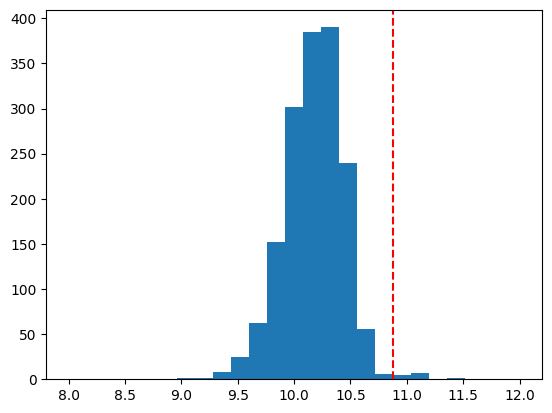

In [16]:
from multicam.tng.utils import TNG_H
plt.hist(stellar_mass_matched, bins=25, range=(8, 12))
plt.axvline(np.log10(5.1 * 1e10 / TNG_H), c='r', linestyle='--') # boryana's cut (2020)

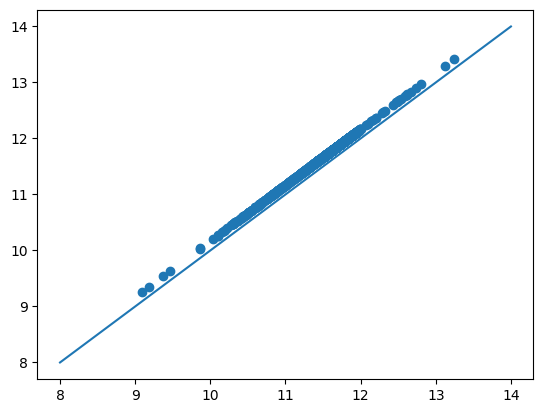

In [17]:
# should be the same!
plt.plot([8, 14], [8, 14])
plt.scatter(mah_bar[:, -1], subhalo_mass_matched)
# small displacement due to that weird group conversation factor that doesn't matter


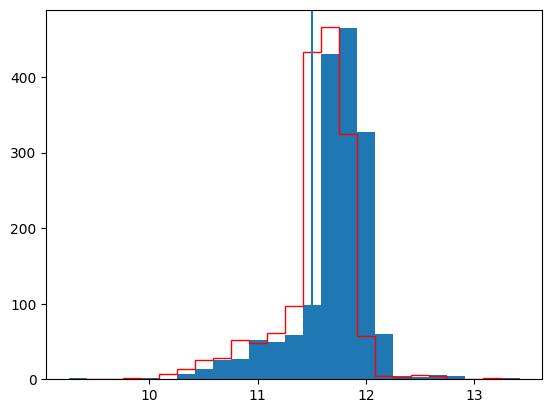

In [18]:
_, bins, _ = plt.hist(subhalo_mass_matched, bins=25)
plt.hist(mah_bar[:, -1], bins=bins, color='r', histtype='step')
plt.axvline(11.5)

In [19]:
# still significant number of haloes below threshold in present day mass
sum(mah_bar[:, -1] < 11.5)

409

In [20]:
# factor
mah_bar[13, -1], subhalo_mass_matched[13] # ~0.2 displacement, but 11.5 cut in mah_bar is more strict

(11.241158, 11.410313)

# Read in colors

In [21]:
from multicam.tng.utils import get_color_and_match
color_file = "../../data/tng/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5"
colors = get_color_and_match(color_file, bar_id)
gr = colors['sdss_g'] - colors['sdss_r']

(array([  2.,   1.,   5.,  14.,  18.,  58.,  77., 111., 152., 167., 155.,
        118.,  94.,  79.,  50.,  47.,  29.,  36.,  42.,  53., 116., 153.,
         55.,   8.,   2.]),
 array([0.1636734 , 0.19245109, 0.22122879, 0.2500065 , 0.27878419,
        0.30756187, 0.33633956, 0.36511725, 0.39389497, 0.42267266,
        0.45145035, 0.48022804, 0.50900573, 0.53778344, 0.5665611 ,
        0.59533882, 0.62411654, 0.6528942 , 0.68167192, 0.71044958,
        0.73922729, 0.76800501, 0.79678267, 0.82556039, 0.85433805,
        0.88311577]),
 <BarContainer object of 25 artists>)

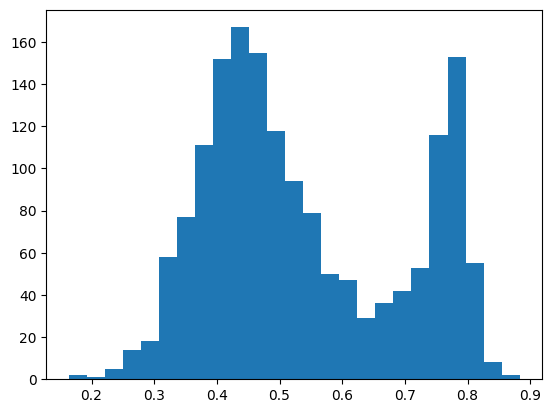

In [22]:
plt.hist(gr, bins=25)

# Add stellar mean deviation

(array([101., 114., 115., 104., 105.,  88.,  74.,  80.,  76.,  64.,  60.,
         62.,  61.,  75.,  64.,  51.,  54.,  57.,  64.,  42.,  37.,  36.,
         25.,  22.,  11.]),
 array([11.50013638, 11.52001572, 11.53989506, 11.5597744 , 11.57965374,
        11.59953403, 11.61941338, 11.63929272, 11.65917206, 11.6790514 ,
        11.69893074, 11.71881008, 11.73868942, 11.75856972, 11.77844906,
        11.7983284 , 11.81820774, 11.83808708, 11.85796642, 11.87784576,
        11.89772511, 11.9176054 , 11.93748474, 11.95736408, 11.97724342,
        11.99712276]),
 <BarContainer object of 25 artists>)

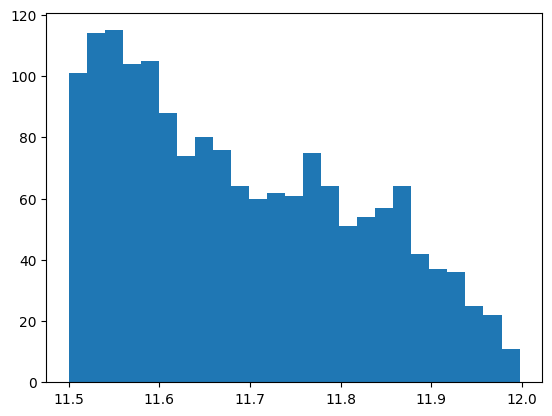

In [37]:
plt.hist(bar_mpeak_pre, bins=25)

In [49]:
from multicam.tng.utils import get_msmhmr
dev_msmhmr, (m, b) = get_msmhmr(stellar_mass_matched, bar_mpeak_pre, mass_bin=(11.5, 12), n_bins=11)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,  10.,  31., 115.,
        318., 629., 397., 110.,  12.,   4.,   8.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.]),
 array([-2.        , -1.84000003, -1.67999995, -1.51999998, -1.36000001,
        -1.20000005, -1.03999996, -0.88      , -0.72000003, -0.56      ,
        -0.40000001, -0.23999999, -0.08      ,  0.08      ,  0.23999999,
         0.40000001,  0.56      ,  0.72000003,  0.88      ,  1.03999996,
         1.20000005,  1.36000001,  1.51999998,  1.67999995,  1.84000003,
         2.        ]),
 <BarContainer object of 25 artists>)

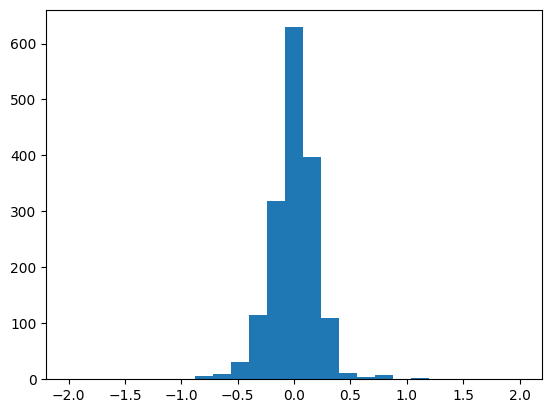

In [52]:
plt.hist(dev_msmhmr, bins=25, range=(-2, 2))

# Correlations with MAH

/Users/imendoza/code/nbody-relaxed/multicam/correlations.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return stats.spearmanr(*args, **kwargs).correlation


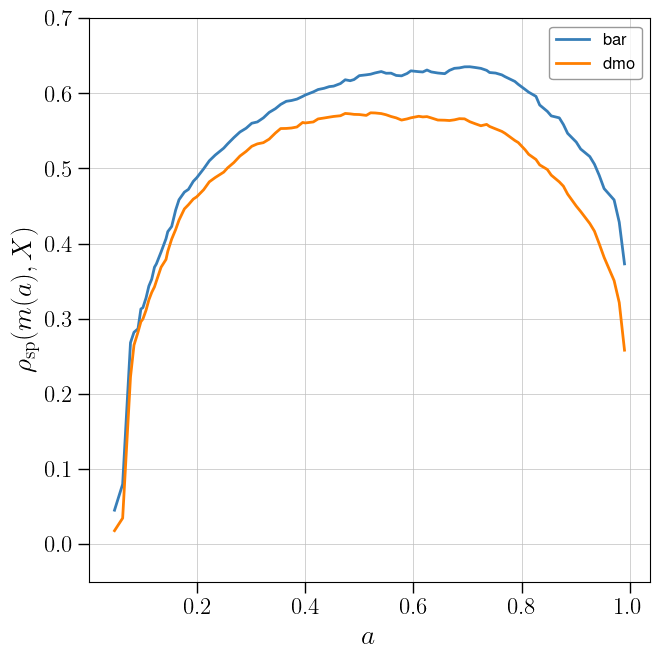

In [232]:

from multicam.correlations import spearmanr
from multicam.plotting import LATEX_PARAMS_TNG, set_rc
set_rc()


colors =['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 
         'C6'
         ]


fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for ii, mpeak in enumerate([mpeak_bar, mpeak_dmo]):
    color= colors[ii]
    corrs = []
    for jj in range(mpeak_bar.shape[1]):
        corrs.append(spearmanr(gr, mpeak[:, jj]))


    corrs = np.array(corrs)
    scales_neg = scales[corrs < 0]
    scales_pos = scales[corrs > 0]
    corrs_neg = abs(corrs[corrs < 0])
    corrs_pos = abs(corrs[corrs > 0])

    label = LATEX_PARAMS_TNG['g-r']
    if len(scales_pos) > 0:
        ax.plot(scales_pos, corrs_pos, label='bar' if ii==0 else 'dmo', ls='-', color=color)
        label = None
    if len(scales_neg) > 0:
        ax.plot(scales_neg, corrs_neg, label='bar' if ii==0 else 'dmo', ls='--', color=color)



ax.legend(prop={'size': 12})
ax.set_ylabel(r'$\rho_{\rm sp}(m(a), X)$')

ax.set_xlabel(r'$a$')
ax.set_ylim(-0.05, 0.7)


plt.tight_layout()



/Users/imendoza/code/nbody-relaxed/multicam/correlations.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return stats.spearmanr(*args, **kwargs).correlation


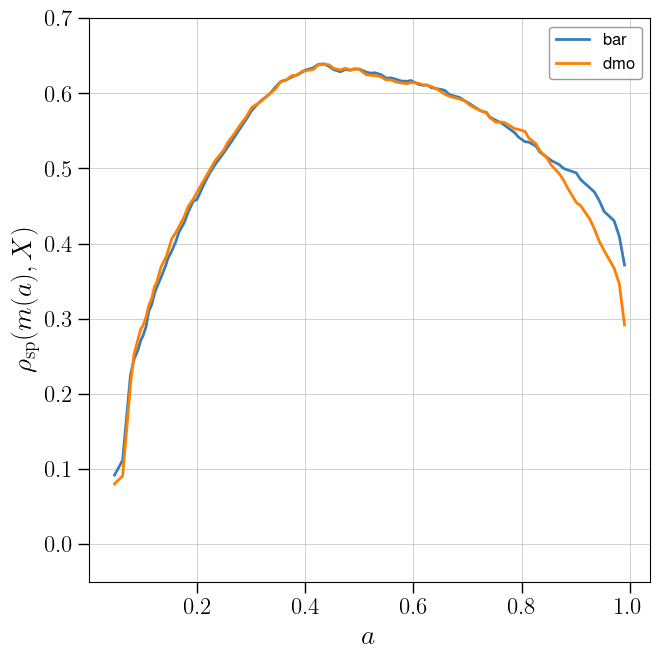

In [54]:

from multicam.correlations import spearmanr
from multicam.plotting import LATEX_PARAMS_TNG, set_rc
set_rc()


colors =['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 
         'C6'
         ]


fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for ii, mpeak in enumerate([mpeak_bar, mpeak_dmo]):
    color= colors[ii]
    corrs = []
    for jj in range(mpeak_bar.shape[1]):
        corrs.append(spearmanr(dev_msmhmr, mpeak[:, jj]))


    corrs = np.array(corrs)
    scales_neg = scales[corrs < 0]
    scales_pos = scales[corrs > 0]
    corrs_neg = abs(corrs[corrs < 0])
    corrs_pos = abs(corrs[corrs > 0])

    label = LATEX_PARAMS_TNG['msmhmr']
    if len(scales_pos) > 0:
        ax.plot(scales_pos, corrs_pos, label='bar' if ii==0 else 'dmo', ls='-', color=color)
        label = None
    if len(scales_neg) > 0:
        ax.plot(scales_neg, corrs_neg, label='bar' if ii==0 else 'dmo', ls='--', color=color)



ax.legend(prop={'size': 12})
ax.set_ylabel(r'$\rho_{\rm sp}(m(a), X)$')

ax.set_xlabel(r'$a$')
ax.set_ylim(-0.05, 0.7)


plt.tight_layout()



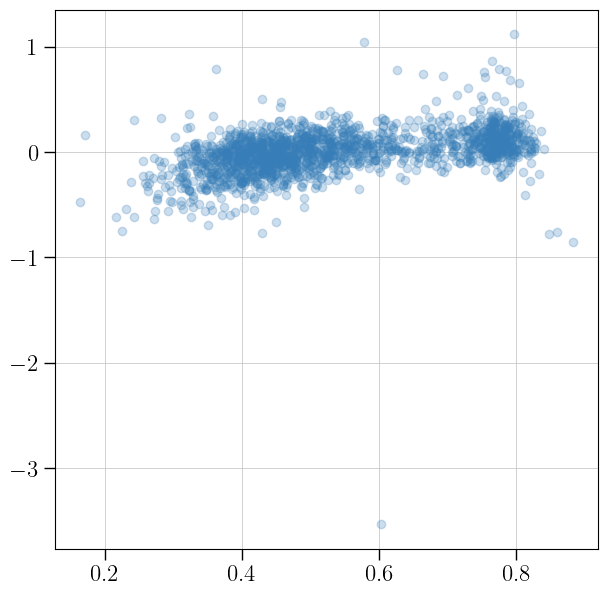

In [91]:
plt.scatter(gr, dev_msmhmr, alpha=0.25)

# Use MultiCAM to get correlations 

In [55]:
from multicam.models import MultiCAM

In [56]:
gr.shape, dev_msmhmr.shape

((1642,), (1642,))

In [60]:
gr.values

array([0.6545582 , 0.6692581 , 0.6854477 , ..., 0.76745796, 0.7758045 ,
       0.7737045 ], dtype=float32)

In [66]:
model_bar = MultiCAM(mpeak_bar.shape[-1], 2)
model_dmo = MultiCAM(mpeak_dmo.shape[-1], 2)

y = np.hstack([gr.values.reshape(-1, 1), dev_msmhmr.reshape(-1,1)])


model_dmo.fit(mpeak_dmo, y)
model_bar.fit(mpeak_bar, y)

In [67]:
y_pred_dmo = model_dmo.predict(mpeak_dmo)
y_pred_bar = model_bar.predict(mpeak_bar)

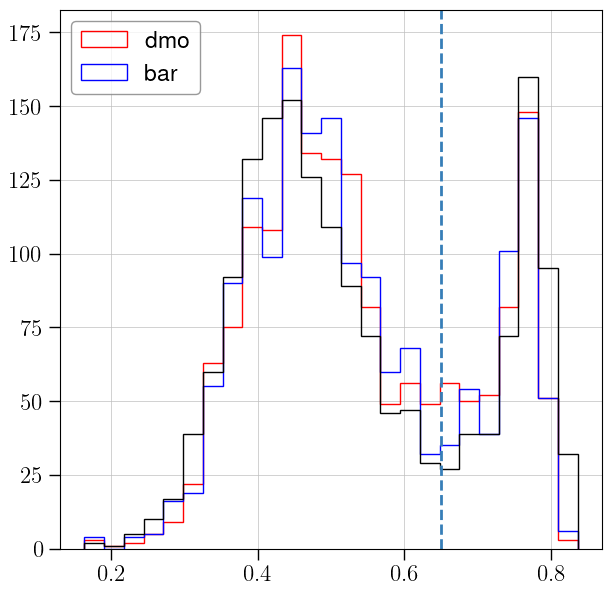

In [76]:
# check distributions are the same (color)
_, bins, _ = plt.hist(y_pred_dmo[:, 0], histtype='step', color='r', bins=25, label='dmo')
plt.hist(y_pred_bar[:, 0], histtype='step', color='b', bins=bins, label='bar')
plt.hist(y[:, 0], histtype='step', color='k', bins=bins)
plt.axvline(0.65, linestyle='--')
plt.legend()
# are these actually different? 
# try kolmogarov smirnoff test; 

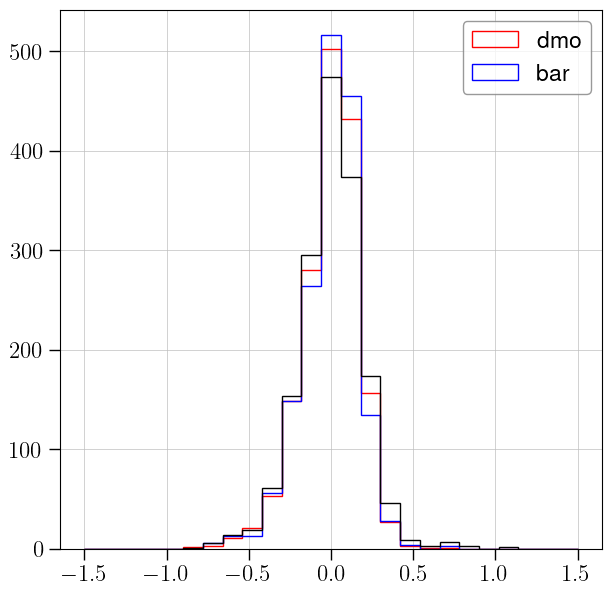

In [75]:
# check distributions are the same (mshmsr)
_, bins, _ = plt.hist(y_pred_dmo[:, 1], histtype='step', color='r', bins=25, label='dmo', range=(-1.5, 1.5))
plt.hist(y_pred_bar[:, 1], histtype='step', color='b', bins=bins, label='bar')
plt.hist(y[:, 1], histtype='step', color='k', bins=bins)
plt.legend()


In [94]:
from multicam.models import MultiCamSampling
model_scatter_dmo = MultiCamSampling(mpeak_dmo.shape[-1], 2)
model_scatter_dmo.fit(mpeak_dmo, y)

In [95]:
y_sampled = model_scatter_dmo.sample(mpeak_dmo)

In [96]:
y_sampled.shape

(1642, 2)

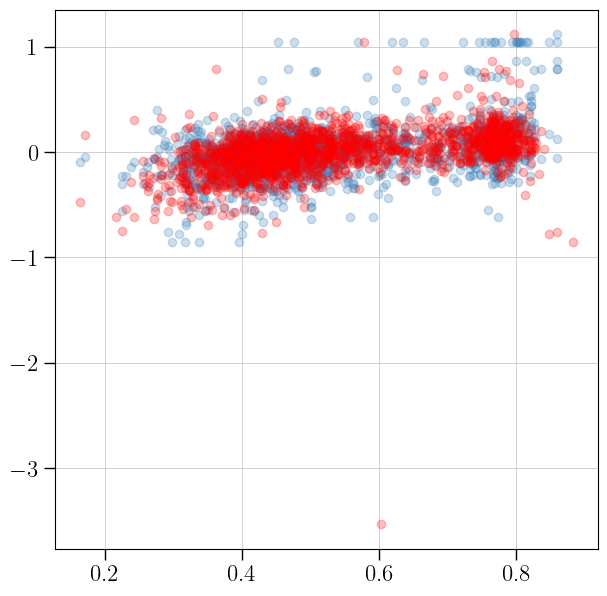

In [98]:
plt.scatter(y_sampled[:, 0], y_sampled[:, 1], alpha=0.25) # probably need to scatter, case with strong correlation between two variables 
plt.scatter(y[:, 0], y[:, 1], alpha=0.25, color='r')

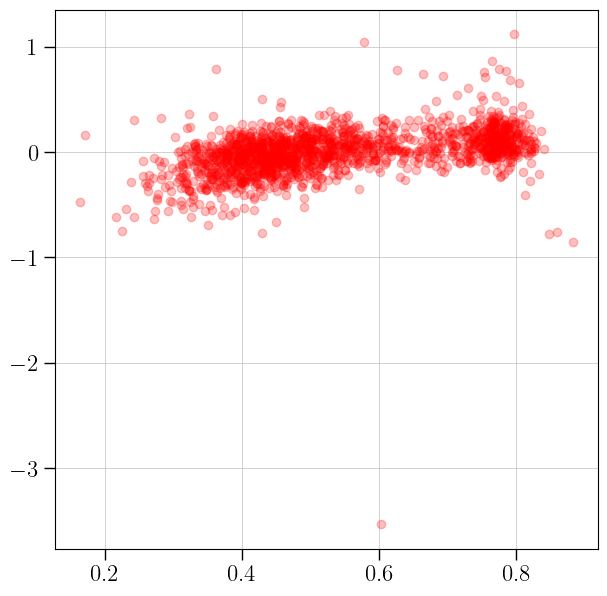

In [104]:
# plt.scatter(y_pred_dmo[:, 0], y_pred_dmo[:, 1], alpha=0.25) # probably need to scatter, case with strong correlation between two variables 
plt.scatter(y[:, 0], y[:, 1], alpha=0.25, color='r')

# Color classification and deviation

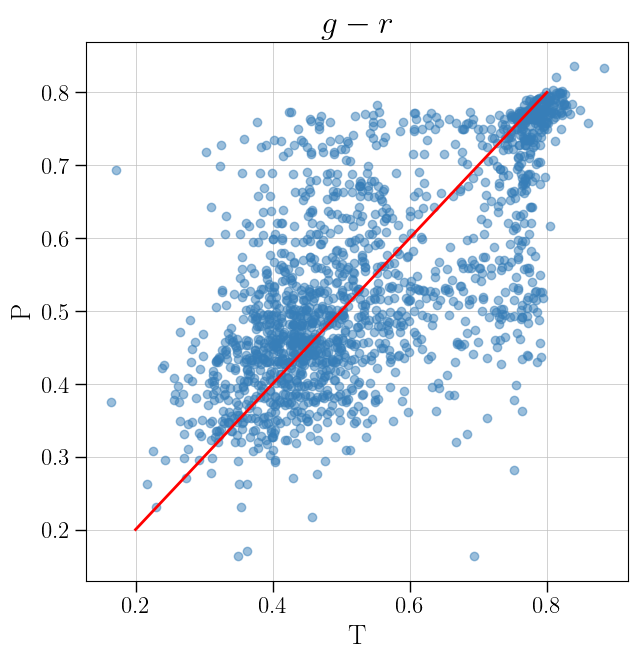

In [102]:
pred_color = y_pred_dmo[:, 0]
true_color = y[:, 0]

plt.scatter(true_color, pred_color, alpha=0.5)
plt.ylabel(r"\rm P")
plt.xlabel(r"\rm T")
plt.title("$g-r$")
plt.plot([0.2, 0.8], [0.2, 0.8], color='r')

In [100]:
# pred_color = y_pred_bar[:, 0]
# true_color = y[:, 0]

# plt.scatter(true_color, (pred_color - true_color) / true_color, alpha=0.5)
# plt.ylabel(r"\rm (P-T) / T")
# plt.xlabel(r"\rm T")
# plt.title("$g-r$")

In [121]:
# confusion matrix
from sklearn.metrics import confusion_matrix
pred_color = y_pred_dmo[:, 0]
true_color = y[:, 0]
pred_red = pred_color < 0.65
true_red = true_color < 0.65
# pred_blue = pred_color > 0.65
# true_blue = true_color > 0.65

conf_matrix = confusion_matrix(pred_red.astype(float), true_red.astype(float))
tn, fp, fn, tp = conf_matrix.ravel()
print("confusion matrix (predict blue and blue; predict blue and red; predict red and blue; predict red and red):")
print(conf_matrix)
print("recall and precision (red):")
print(tp / true_red.sum(), tp / pred_red.sum())

print("recall and precision (blue):")
print(tn / (~true_red).sum(), tn / (~pred_red).sum())

confusion matrix (predict blue and blue; predict blue and red; predict red and blue; predict red and red):
[[ 313  129]
 [ 155 1045]]
recall and precision (red):
0.8901192504258943 0.8708333333333333
recall and precision (blue):
0.6688034188034188 0.7081447963800905


In [88]:
# number of correctly classified galaxies
# make a more visually appealing version ; maybe a venn diagram? 
# correlation coefficient that works for classification problems. 
# do with sampling 


print("")
sum(
    (pred_color < 0.65) & (true_color < 0.65)
) / sum((true_color < 0.65)), sum(
    (pred_color < 0.65) & (true_color < 0.65)
) / sum((pred_color < 0.65)), sum(
    (pred_color > 0.65) & (true_color > 0.65)
) / sum((true_color > 0.65)), sum(
    (pred_color > 0.65) & (true_color > 0.65)
) / sum((pred_color > 0.65))

(0.8901192504258943,
 0.8708333333333333,
 0.6688034188034188,
 0.7081447963800905)

In [89]:
# number of correctly classified galaxies
pred_color = y_pred_bar[:, 0]
true_color = y[:, 0]

sum(
    (pred_color < 0.65) & (true_color < 0.65)
) / sum((true_color < 0.65)), sum(
    (pred_color < 0.65) & (true_color < 0.65)
) / sum((pred_color < 0.65)), sum(
    (pred_color > 0.65) & (true_color > 0.65)
) / sum((true_color > 0.65)), sum(
    (pred_color > 0.65) & (true_color > 0.65)
) / sum((pred_color > 0.65))

(0.9173764906303237,
 0.8900826446280992,
 0.7158119658119658,
 0.7754629629629629)

# output and save final catalog to use

In [48]:
mah_dmo.shape

(1642, 100)

In [ ]:
dmo_cat ={
    'mvir': mah_dmo[:,-1], 
    'mpeak_mah': mpeak_dmo, 

 
 }

bar_cat ={
    'mvir': mah_bar[:, -1],
    'mpeak_mah': mpeak_bar, 
    'stear_mass': stellar_mass_matched,
}